<a href="https://colab.research.google.com/github/armiro/Pneumothorax-Segmentation/blob/master/pnx_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import glob, cv2, gzip, gc
 
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, concatenate, Lambda
from tensorflow.keras import Model, backend as K, callbacks as cb

In [2]:
# load the dataset
path = '/content/drive/MyDrive/Datasets/siim_acr_pneumothorax_seg/'
img_file = gzip.GzipFile(filename=path+'training_images.npy.gz', mode='r')
%time images = np.load(file=img_file)
msk_file = gzip.GzipFile(filename=path+'training_masks_resized.npy.gz', mode='r')
%time masks = np.load(file=msk_file)
metadata = pd.read_csv(filepath_or_buffer=path+'converted-train-rle.csv', index_col=None)
age = metadata.loc[:, 'PatientAge']
sex = metadata.loc[:, 'PatientSex']
view = metadata.loc[:, 'ImageView']

print('metadata columns:', metadata.columns)
print('shape of the dataset:', images.shape)
print('shape of the masks:', masks.shape)

CPU times: user 29.6 s, sys: 1.6 s, total: 31.2 s
Wall time: 32.5 s
CPU times: user 8.76 s, sys: 618 ms, total: 9.38 s
Wall time: 49.1 s
metadata columns: Index(['ImageId', 'PatientId', 'PatientAge', 'PatientSex', 'ImageView'], dtype='object')
shape of the dataset: (12047, 512, 512)
shape of the masks: (12047, 512, 512)


In [3]:
# because of memory limit, manual data splitter is defined so that we can split 
# images and masks in different steps and delete unnecessary variables in between
def manual_train_test_split(data, test_ratio, init_indices):
    if init_indices is not None:
        shuffle_indices = init_indices
    else:
        shuffle_indices = np.random.RandomState(seed=23).permutation(len(data))
    test_size = int(test_ratio * len(data))
    test_indices = shuffle_indices[:test_size]
    train_indices = shuffle_indices[test_size:]
    return data[train_indices], data[test_indices], shuffle_indices
 
 
images = np.expand_dims(images, axis=-1)
X_train, X_val, indices = manual_train_test_split(data=images, test_ratio=0.2, init_indices=None)
del images
gc.collect()
 
masks = np.expand_dims(masks, axis=-1)
y_train, y_val, _ = manual_train_test_split(data=masks, test_ratio=0.2, init_indices=indices)
del masks
gc.collect()

0

In [4]:
# define metrics: dice coefficient (DICE/F1-score) and intersection over union (IoU/Jaccard)
def dice_coef(y_true, y_pred, smooth=1):
    overlap = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    total_area = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dsc = K.mean((2.0 * overlap + smooth) / (total_area + smooth), axis=0)
    return dsc
 
 
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

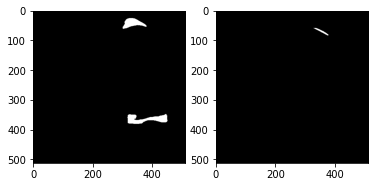

inter-dice is: tf.Tensor(0.00023685457129322596, shape=(), dtype=float64) and inter-jaccard is: tf.Tensor(0.00023685457129322596, shape=(), dtype=float64)
self-dice is: tf.Tensor(1.0, shape=(), dtype=float64) and self-jaccard is: tf.Tensor(1.0, shape=(), dtype=float64)


In [5]:
# test masks to see if both DSC ans IoU metrics are working correctly
im1 = np.expand_dims(y_train[22], axis=0).astype('float64')
im2 = np.expand_dims(y_train[12], axis=0).astype('float64')
 
plt.subplot(1, 2, 1)
plt.imshow(X=np.squeeze(im1, axis=(0, -1)), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(X=np.squeeze(im2, axis=(0, -1)), cmap='gray')
plt.show()
 
print('inter-dice is:', dice_coef(im1, im2), 'and inter-jaccard is:', iou_coef(im1, im2))
print('self-dice is:', dice_coef(im1, im1), 'and self-jaccard is:', iou_coef(im1, im1))

In [ ]:
print(np.max(X_train[22]), np.min(X_train[22]), np.mean(X_train[22]), np.median(X_train[22]))

255 0 102.93886947631836 99.0


In [ ]:
print(np.max(y_train[22]), np.min(y_train[22]), np.mean(y_train[22]), np.median(y_train[22]))

1 0 0.015094757080078125 0.0


In [6]:
# model architecture: vanilla unet
def vanilla_unet(input_size=(512,512,1)):
    inputs = Input(input_size)
    ds_inputs = Lambda(lambda image: image/255.0, name='down_scaler')(inputs)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(ds_inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # pool1 = Dropout(rate=0.1)(pool1)
    
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # pool2 = Dropout(rate=0.1)(pool2)
 
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # pool3 = Dropout(rate=0.1)(pool3)
 
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    # pool4 = Dropout(rate=0.1)(pool4)
 
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    # conv5 = Dropout(rate=0.1)(conv5)
 
    up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    # conv6 = Dropout(rate=0.1)(conv6)
 
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)
    # conv7 = Dropout(rate=0.1)(conv7)
 
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)
    # conv8 = Dropout(rate=0.1)(conv8)
 
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    # conv9 = Dropout(rate=0.1)(conv9)
 
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
 
    return Model(inputs=[inputs], outputs=[conv10], name='segmentor')
 
 
model = vanilla_unet(input_size=(512, 512, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, iou_coef])
model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)

Model: "segmentor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
down_scaler (Lambda)            (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         down_scaler[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________

In [7]:
# define image augmentation function using keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
 
img_aug = ImageDataGenerator(rotation_range=170, horizontal_flip=True, vertical_flip=True, 
                             zoom_range=[0.9, 1.5], brightness_range=[0.7, 1.2], rescale=None,
                             width_shift_range=0.15, height_shift_range=0.15, fill_mode='constant', 
                             zca_whitening=False, dtype='uint8')

In [8]:
def batch_loader(X, y, batch_size):
    rnd_seed = np.random.randint(400)
    rnd_indices = np.random.choice(X.shape[0], batch_size)
    X_batch = list()
    y_batch = list()
    for idx in rnd_indices:
        X_batch.append(X[idx])
        y_batch.append(y[idx])
    
    # print(type(X_batch[0][0][0][0]))
    # print(np.max(X_batch), np.max(y_batch))
    # if np.max(y_batch) == 1:
    #     plt.imshow(np.squeeze(X_batch, axis=(0, -1)), cmap='gray')
    #     plt.show()
    #     plt.imshow(np.squeeze(y_batch, axis=(0, -1)), cmap='gray')
    #     plt.show()
 
    gen_img = img_aug.flow(np.array(X_batch), batch_size=batch_size, shuffle=False, seed=rnd_seed)
    gen_msk = img_aug.flow(np.array(y_batch), batch_size=batch_size, shuffle=False, seed=rnd_seed)
    X_batch.clear()
    y_batch.clear()
    X_batch = gen_img.next().astype('uint8')
    y_batch = gen_msk.next()
    y_batch = [np.where(mask > 0, 1, 0) for mask in y_batch]
    return np.array(X_batch), np.array(y_batch)

<class 'numpy.uint8'>
244 1


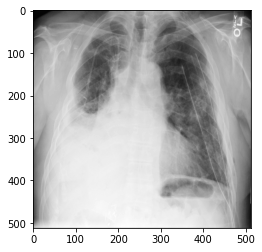

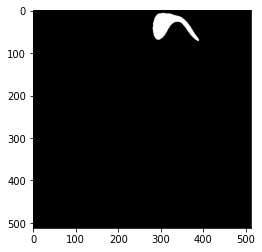

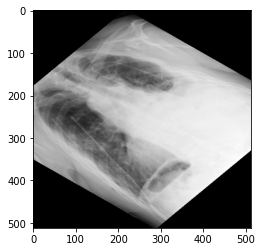

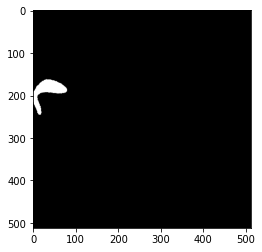

200 1
<class 'numpy.uint8'>


In [ ]:
# test to see if data augmentation is working correctly for the masks

xt, yt = batch_loader(X=X_train, y=y_train, batch_size=1)
plt.imshow(np.squeeze(xt, axis=(0, -1)), cmap='gray')
plt.show()
plt.imshow(np.squeeze(yt, axis=(0, -1)), cmap='gray')
plt.show()
print(np.max(xt), np.max(yt))
print(type(xt[0][0][0][0]))

In [ ]:
# # data augmentation tester
# tmp = aug.flow(np.expand_dims(X_train[60], axis=0), seed=13)
# tmx = aug.flow(np.expand_dims(y_train[60], axis=0), seed=13)
# this = tmp.next()
# that = tmx.next()

# plt.imshow(np.squeeze(this, axis=(0, -1)), cmap='gray', vmin=0, vmax=255)
# plt.show()
# plt.imshow(np.squeeze(that, axis=(0, -1)), cmap='gray', vmin=0, vmax=1)
# plt.show()

In [9]:
# define training callbacks
checkpoint = cb.ModelCheckpoint('/content/drive/My Drive/pnx_model/eps={epoch:03d}_valLoss={val_loss:.4f}.hdf5',
                                monitor='val_loss', verbose=2, save_best_only=True, mode='auto')
cb_list = [checkpoint]

In [ ]:
# model.load_weights('/content/drive/MyDrive/pnx_model/eps=022_valLoss=0.0114.hdf5')

In [10]:
num_epochs = 20000
# losses = list()
# i = 4
for num_epoch in np.arange(0, num_epochs):
    xb, yb = batch_loader(X=X_train, y=y_train, batch_size=32)
    # plt.imshow(xb[i].squeeze(), cmap='bone', vmin=0, vmax=255)
    # plt.show()
    # print('max px in img:', np.max(xb[i]))
    # plt.imshow(yb[i].squeeze(), cmap='gray', vmin=0, vmax=1)
    # plt.show()
    # print('max px in mask:', np.max(yb[i]), 'and unique mask vals:', np.unique(yb[i]))
    # break
    loss = model.train_on_batch(x=xb, y=yb)
    ckp = len(X_train) // 32.0
    # print(loss)
    if (num_epoch / ckp).is_integer():
            # print('epoch:', num_epoch/ckp, ' || ', 'bce_loss:', round(loss[0], 4), ' || ', 
            #       'dice_coef:', round(loss[1], 4), ' || ', 'iou_coef:', round(loss[2], 4))
            model.evaluate(x=X_val, y=y_val, verbose=1, callbacks=cb_list)
    # losses.append(loss)
 
 
# fig = plt.figure(figsize=(15, 4))
# plt.subplot(1, 3, 1)
# plt.plot(training.history['loss'], color='r', label='training_loss')
# plt.plot(training.history['val_loss'], color='g', label='validation_loss')
# plt.legend()
# plt.subplot(1, 3, 2)
# plt.plot(training.history['dice_coef'], color='r', label='training_dsc')
# plt.plot(training.history['val_dice_coef'], color='g', label='validation_dsc')
# plt.legend()
# plt.subplot(1, 3, 3)
# plt.plot(training.history['iou_coef'], color='r', label='training_iou')
# plt.plot(training.history['val_iou_coef'], color='g', label='validation_iou')
# plt.legend()
# plt.show()
# fig.savefig('/content/drive/My Drive/pnx_model/training.png', bbox_inches='tight')

76/76 [==============================] - 8s 109ms/step - loss: 0.5666 - dice_coef: 0.4578 - iou_coef: 0.4576


KeyboardInterrupt: ignored

In [ ]:
# model.save('/content/drive/MyDrive/pnx_model/this_model.hdf5')
# model.load_weights('/content/drive/MyDrive/pnx_model/01_eps=022_valLoss=0.0114.hdf5')

4395


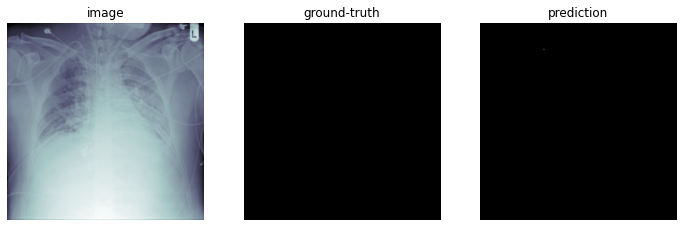

In [48]:
idx = np.random.randint(0, len(X_train))
# idx = 6994
print(idx)
fig = plt.figure(num=3, figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('image')
plt.imshow(X=X_train[idx].squeeze(), cmap='bone')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('ground-truth')
plt.imshow(X=y_train[idx].squeeze(), cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('prediction')
pred = model.predict(np.expand_dims(X_train[idx], axis=0))
# pred = np.where(pred>0.000005, 1, 0)
plt.imshow(X=np.squeeze(pred, axis=(0, -1)), cmap='gray')
plt.axis('off')
plt.show()
# fig.savefig('/content/drive/MyDrive/unet_v1_XX.png', bbox_inches='tight')